In [94]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import os.path
from sklearn.metrics import precision_score, recall_score,confusion_matrix, f1_score
from sklearn import ensemble, metrics, model_selection, 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

clean_data_folder = "C:\\Users\\nateb\\OneDrive\\Desktop\\Data Science Projects\\datasets\\NFL\\Clean"
#read in data:
df = pd.DataFrame(pd.read_excel( "C:\\Users\\nateb\\OneDrive\\Desktop\\Data Science Projects\\datasets\\NFL\\Clean\\Historical Game DF averages 1999-2019.xlsx"))



First - I need to remove some variables that have too many NaN values or contain information from the game I are trying to predict

I also want to avoid having a model that will consistantly choose the favorite - so I am removing it for the time being

In the end, I'll compare these different models to the strategy of just choosing the favorite everytime

In [115]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection


df2 = df.drop(
    ['home_avg_median_air_yards',
    'home_avg_yac',
    'away_avg_median_air_yards',
    'away_avg_yac',
    'away_winner',
    'home_score',
    'away_score',
    'weather_temp',
    'weather_humidity',
    'weather_wind',
    'home_team',
    'away_team',
    'total',
    'total_line',
    'game_id',
    'home_against_avg_median_air_yards',
    'away_against_avg_median_air_yards',
    'home_avg_win_gap',
    'away_avg_win_gap',
    'home_against_avg_win_gap',
    'away_against_avg_win_gap'
    ],axis=1)


df2.head()

,season,week,home_avg_first_down_yards,home_avg_second_down_yards,home_avg_4down_converted,home_avg_offensive_touchdown,home_avg_defensive_touchdown,home_avg_rush_touchdown,home_avg_pass_touchdown,home_avg_return_touchdown,...,away_total_ties,indoors,div_game,home_winner,home_spread,away_spread,home_days_rest,away_days_rest,base_predictions,correct_predictions
0,1999,2,2.774194,4.884615,0.000000,3.000000,0.000000,1.000000,2.000000,0.000000,...,0,0,0,0,6.5,-6.5,7,7,0,1
1,1999,5,3.528796,4.417682,0.000000,0.750000,0.250000,0.250000,0.500000,0.000000,...,0,0,1,1,9.5,-9.5,7,7,0,0
2,1999,8,4.062543,4.426144,0.285714,0.857143,0.285714,0.142857,0.714286,0.000000,...,0,0,1,0,2.5,-2.5,7,7,0,1
3,1999,10,4.179679,4.615009,0.333333,1.000000,0.222222,0.333333,0.666667,0.111111,...,0,0,1,1,6.0,-6.0,7,7,0,0
4,1999,11,4.385849,4.513508,0.300000,1.200000,0.200000,0.500000,0.600000,0.200000,...,0,0,0,0,7.0,-7.0,7,7,0,1


In [116]:
#check NA
fill_na_vars={}
for x in df2.columns:
    na = df2[x].isnull().sum()
    if na > 0:
        #print(x,na)
        fill_na_vars[x] = na
fill_na_vars

{'home_avg_field_goal_pct': 6,
 'home_against_avg_field_goal_pct': 6,
 'home_avg_td_redzone': 9,
 'home_against_avg_td_redzone': 4,
 'away_avg_field_goal_pct': 10,
 'away_against_avg_field_goal_pct': 10,
 'away_avg_td_redzone': 7,
 'away_against_avg_td_redzone': 11}

In [117]:
# Look at the observations where there is Na and evaluate how to best handle

df_na = df2.loc[df2['away_against_avg_td_redzone'].isnull()]
df_na

,season,week,home_avg_first_down_yards,home_avg_second_down_yards,home_avg_4down_converted,home_avg_offensive_touchdown,home_avg_defensive_touchdown,home_avg_rush_touchdown,home_avg_pass_touchdown,home_avg_return_touchdown,...,away_total_ties,indoors,div_game,home_winner,home_spread,away_spread,home_days_rest,away_days_rest,base_predictions,correct_predictions
265,2000,2,5.236364,6.750000,0.0,3.0,0.0,3.0,0.0,0.0,...,0,1,0,1,-3.0,3.0,7,7,1,1
1175,2003,2,3.890909,5.150000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,1,1,-2.5,2.5,7,7,1,1
1370,2004,2,5.158730,6.318182,1.0,2.0,0.0,1.0,1.0,0.0,...,0,0,0,1,-4.5,4.5,7,7,1,1
1452,2004,2,6.454545,6.510638,1.0,2.0,0.0,2.0,0.0,0.0,...,0,0,1,1,3.0,-3.0,7,7,0,0
2091,2007,2,5.176471,6.073171,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,1,-10.0,10.0,7,7,1,1
2147,2007,2,7.714286,3.666667,0.0,4.0,0.0,1.0,3.0,0.0,...,0,1,1,1,-3.0,3.0,7,7,1,1
2434,2008,2,5.053571,7.416667,1.0,4.0,0.0,3.0,1.0,0.0,...,0,0,1,1,-6.5,6.5,8,8,1,1
2490,2009,2,5.480769,3.351351,0.0,2.0,0.0,1.0,1.0,0.0,...,0,0,0,0,-7.5,7.5,7,7,1,0
2903,2010,2,5.102041,4.547619,0.0,1.0,0.0,0.0,1.0,0.0,...,0,1,0,0,-5.5,5.5,10,7,1,0
2911,2010,2,4.098039,4.162162,2.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,4.5,-4.5,8,11,0,1


These columns have null values in the first couple weeks of the data (data starts at week 2 of each season) because those events did not occur in the previous week.
For example, if the home_avg_field_goal_pct variable is null, it is because the home team did not kick a field goal yet that season

How I will fill the Na values:

    - The field goal values will be filled with the average, because the lack of field goals could mean that they were never in field goal range, or that they managed to score a touchdown everytime they were in field goal range. Additionally, there is not too much variation in kickers.
    
    - Redzone TD variables are null because that team either did not reach the redzone or did not allow the other team to reach the redzone. Those values will be replaced with 0 to most accurately portray the offense/defenses ability.
    
    


In [118]:
df2['home_avg_field_goal_pct'].fillna(df2['home_avg_field_goal_pct'].mean(),inplace=True)
df2['home_against_avg_field_goal_pct'].fillna(df2['home_against_avg_field_goal_pct'].mean(),inplace=True)
df2['away_avg_field_goal_pct'].fillna(df2['away_avg_field_goal_pct'].mean(),inplace=True)
df2['away_against_avg_field_goal_pct'].fillna(df2['away_against_avg_field_goal_pct'].mean(),inplace=True)

df2['home_avg_td_redzone'].fillna(0,inplace=True)
df2['home_against_avg_td_redzone'].fillna(0,inplace=True)
df2['away_avg_td_redzone'].fillna(0,inplace=True)
df2['away_against_avg_td_redzone'].fillna(0,inplace=True)


In [119]:
#Check Again - Good! no more null values


# fill_na_vars={}
# for x in df2.columns:
#     na = df2[x].isnull().sum()
#     if na > 0:
#         #print(x,na)
#         fill_na_vars[x] = na
# fill_na_vars

# Lets check the base case of choosing the favorite every time

In [120]:
df['base_predictions'] = df.apply(lambda x: 1 if x['home_spread'] < 0 else 0, axis = 1)
df['correct_predictions'] = df.apply(lambda x: 1 if x['home_winner'] == x['base_predictions'] else 0, axis = 1)

df['correct_predictions'].mean()

print('picking the favorite is correct {:.2f}% of the time'.format((df['correct_predictions'].mean())*100))



picking the favorite is correct 66.41% of the time


In [121]:
corr_matrix = df2.corr()

In [122]:
winner_corr_matrix = corr_matrix['home_winner'].sort_values(ascending=True)


winner_corr_limited = winner_corr_matrix.loc[abs(winner_corr_matrix) > .1]

# winner_corr_limited

In [123]:
#use sklearn cross validation
from sklearn.model_selection import cross_val_score,cross_val_predict, GridSearchCV

#separate a validation set
x_train = df2.loc[df2['season'] < 2018].drop(['home_winner'],axis=1)
x_test = df2.loc[df2['season'] == 2018].drop(['home_winner'],axis=1)
y_train = df2['home_winner'].loc[df2['season'] < 2018]
y_test = df2['home_winner'].loc[df2['season'] == 2018]
x_final_validation = df2.loc[df2['season'] == 2019].drop(['home_winner'],axis=1)
y_final_validation = df2['home_winner'].loc[df2['season'] == 2019]

standard_scaler = StandardScaler()
scaler = standard_scaler.fit(x_train)
x_train_stan = scaler.transform(x_train)
x_test_stan = scaler.transform(x_test)
x_final_valid_stan = scaler.transform(x_final_validation)


In [124]:
x_train.shape

(4740, 218)

# Random Forest Classifier



In [129]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42,n_jobs=-1)

param_grid = {
    "n_estimators": [100,200,250,300,400,500],
    "max_depth":[1,2,5,7],
    "criterion":["gini","entropy"]
}

model = GridSearchCV(
    estimator=forest_clf,
    param_grid=param_grid,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    cv=3
)
model.fit(x_train,y_train)
print(f"Best score: {model.best_score_}")
print("Best parameters set:")
best_params = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}:{best_params[param_name]}")
#cross_val_score(forest_clf,x_train,y_train,cv=3,scoring="accuracy")
# Best score: 0.9510548523206751
# Best parameters set:
# 	criterion:gini
# 	max_depth:7
# 	n_estimators:500


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   33.9s finished


Best score: 0.9510548523206751
Best parameters set:
	criterion:gini
	max_depth:7
	n_estimators:500


<function matplotlib.pyplot.show(close=None, block=None)>

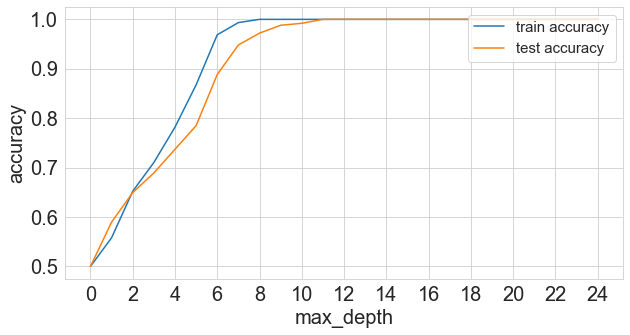

In [134]:
# Looks like the model could be overfitting - I'm going to make a chart for the max_depth variable to look in to this

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rc('xtick',labelsize=20)
matplotlib.rc('ytick',labelsize=20)
%matplotlib inline
train_accuracies = [0.5]
test_accuracies = [0.5]
for depth in range(1,25):

    tree_clf2 = RandomForestClassifier(criterion="gini",max_depth=depth,n_estimators=500)
    tree_clf2.fit(x_train,y_train)
    train_predictions = tree_clf2.predict(x_train)
    test_predictions = tree_clf2.predict(x_test)
    train_accuracy = metrics.accuracy_score(y_train,train_predictions)
    test_accuracy = metrics.accuracy_score(y_test,test_predictions)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
plt.plot(train_accuracies,label="train accuracy")
plt.plot(test_accuracies,label="test accuracy")
plt.legend(loc="upper right",prop={'size':15})
plt.xticks(range(0,26,2))
plt.xlabel("max_depth",size=20)
plt.ylabel("accuracy",size=20)
plt.show

# 7 looks to be good

In [ ]:
final_R_forest_clf = RandomForestClassifier(random_state=42,n_jobs=-1,criterion="gini",max_depth=7,n_estimators=500)

# Logostic Regression

In [135]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=10000,dual=False,solver="liblinear")
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
log_reg.fit(x_train_stan,y_train)
predictions = log_reg.predict(x_train_stan)
# accuracy_score = log_reg.score(x_test,y_test)
cross_val_score(log_reg,x_train_stan,y_train,cv=3,scoring="accuracy")


array([0.70886076, 0.75632911, 0.65632911])

In [136]:
c_lst = [x for x in range(1,20)]
c_lst.append(.001)
c_lst.append(.01)
#print(c_lst)
param_grid = {
    "penalty": ["l1","l2"],
    "C":c_lst
}

model = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    cv=3
)
model.fit(x_train_stan,y_train)
print(f"Best score: {model.best_score_}")
print("Best parameters set:")
best_params = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}:{best_params[param_name]}")
    
# Best score: 0.7970464135021098
# Best parameters set:
# 	C:0.01
# 	penalty:l1

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.7s


Best score: 0.7970464135021098
Best parameters set:
	C:0.01
	penalty:l1


[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:  1.8min finished


In [139]:
from sklearn.pipeline import make_pipeline
final_log_reg = make_pipeline(StandardScaler(),LogisticRegression(max_iter=10000,dual=False,solver="liblinear",C=.01,penalty="l1"))

# Support Vector Machine

In [140]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
svm_clf = LinearSVC(dual=False)
svm_clf.fit(x_train_stan,y_train)
cross_val_score(svm_clf,x_train_stan,y_train,cv=3,scoring="accuracy")

array([0.70443038, 0.76455696, 0.65822785])

In [141]:

# svc_clf = LinearSVC(dual=False,max_iter=100000)


In [143]:
#squared_hinge
c_lst = [x for x in range(1,10)]
c_lst.append(.001)
c_lst.append(.01)
param_grid = {
    "C":c_lst,
    "penalty": ["l1"],
    "loss" : ["squared_hinge"],
}

model = GridSearchCV(
    estimator=svm_clf,
    param_grid=param_grid,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    cv=3
)
model.fit(x_train_stan,y_train)
print(f"Best score: {model.best_score_}")
print("Best parameters set:")
best_params = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}:{best_params[param_name]}")
    
# Best score: 0.8497890295358651
# Best parameters set:
# 	C:0.001
# 	loss:squared_hinge
# 	penalty:l1

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best score: 0.8497890295358651
Best parameters set:
	C:0.001
	loss:squared_hinge
	penalty:l1


[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    8.7s finished


In [144]:
final_svm_clf= make_pipeline(StandardScaler(),LinearSVC(dual=False,max_iter=100000,C=.001,loss="squared_hinge",penalty="l1"))

# Decision Tree Classifier

In [145]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(x_train_stan,y_train)
cross_val_score(tree_clf,x_train_stan,y_train,cv=3,scoring="accuracy")

array([1., 1., 1.])

In [147]:
#"n_estimators": [120,200,250,300,400,500],
param_grid = {
    "max_depth":[1,2,5,7,10],
    "criterion":["gini","entropy"],
    "min_samples_split":[1.0,2,5,10,15,100],
    "min_samples_leaf": [1.0,2,5,10],
    "max_features":[None,"auto","sqrt","log2"]
}

model = GridSearchCV(
    estimator=tree_clf,
    param_grid=param_grid,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    cv=5
)
model.fit(x_train_stan,y_train)
print(f"Best score: {model.best_score_}")
print("Best parameters set:")
best_params = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}:{best_params[param_name]}")
    


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 4254 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   20.8s finished


Best score: 1.0
Best parameters set:
	criterion:gini
	max_depth:5
	max_features:None
	min_samples_leaf:2
	min_samples_split:2


In [49]:
final_tree_clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    max_features='auto',
    min_samples_leaf = 5,
    min_samples_split = 100)

<function matplotlib.pyplot.show(close=None, block=None)>

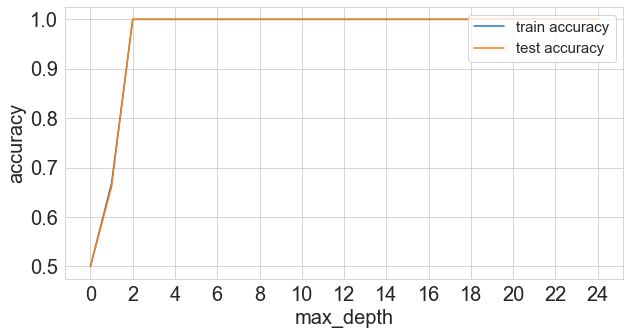

In [148]:
#Looks like we may be overfitting ..  lets make a plot to show 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rc('xtick',labelsize=20)
matplotlib.rc('ytick',labelsize=20)
%matplotlib inline
train_accuracies = [0.5]
test_accuracies = [0.5]
for depth in range(1,25):

    tree_clf2 = DecisionTreeClassifier(max_features=None,min_samples_leaf = 2,min_samples_split=2,criterion="gini",max_depth=depth)
    tree_clf2.fit(x_train,y_train)
    train_predictions = tree_clf2.predict(x_train)
    test_predictions = tree_clf2.predict(x_test)
    train_accuracy = metrics.accuracy_score(y_train,train_predictions)
    test_accuracy = metrics.accuracy_score(y_test,test_predictions)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
plt.plot(train_accuracies,label="train accuracy")
plt.plot(test_accuracies,label="test accuracy")
plt.legend(loc="upper right",prop={'size':15})
plt.xticks(range(0,26,2))
plt.xlabel("max_depth",size=20)
plt.ylabel("accuracy",size=20)
plt.show

# IT looks like the test accuracy peaks at a max depth of 2

# Voting Classifier to bring all of these together

So far, we have not found the right model that will beat just picking the favorite, but perhaps bringing all of this together will do the trick


In [151]:
final_tree_clf = DecisionTreeClassifier(max_features=None,min_samples_leaf = 2,min_samples_split=2,criterion="gini",max_depth=2)

In [154]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

voting_clf = VotingClassifier(
    estimators=[('Rtree',final_R_forest_clf),('svm',final_svm_clf),('tree',final_tree_clf),('logreg',final_log_reg)],
    voting='hard'
)
voting_clf.fit(x_train,y_train)
pred = voting_clf.predict(x_test)
accuracy_score(y_test,pred)
#cross_val_score(voting_clf,x_train,y_train,cv=3,scoring="accuracy")


0.8605577689243028

86% ! Now we need to take a look at the predictions to see where it is most accurate and where it is least accurate like:
    
    - How does the model perfrom under small spreads when the teams are even?
    - How often does the model predict an upset?
    - Does the model perform better on later weeks when there is more data for that team? if so, how much?
    - How does the model perform during the playoffs?

In [156]:
pred = voting_clf.predict(x_final_validation)
accuracy_score(y_final_validation,pred)

0.8685258964143426

Nice! The model did even better on the unseen data